In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random

from redTools import *
from Kcorrect import *

from matplotlib import rcParams
rcParams["font.size"] = 14
rcParams["text.usetex"] = True
rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"

####################################### Set Axes
def set_axes(ax_list, xlim, ylim):
    for ax in ax_list:
        
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=6, width=1.5, direction='in')
        ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
####################################### Plotting Function
def makePlot(x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst, \
        xlim, ylim, xlabel, ylabel, plotName='test'):

    fig = py.figure(figsize=(17, 5), dpi=100)    
    fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
    gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1]) 
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])
    ax_list  = [ax1,ax2,ax3]
    x0 = 0.9*xlim[0]+0.1*xlim[1]
    y0 = 0.15*ylim[0]+0.85*ylim[1]    

    delta = y_trn-p_y_trn
    ax = ax_list[0]
    ax.plot(y_trn, delta, 'g.', alpha=0.3)
    ax.set_title('Training Set', fontsize=18)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.text(x0,y0, 'RMS = '+'%.2f'%np.std(delta), fontsize=16, color='k')
    
    delta = y_cvl-p_y_cvl
    ax = ax_list[1]
    ax.plot(y_cvl, delta, 'r.', alpha=0.7)
    ax.set_title('Cross Validation Set', fontsize=18)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.text(x0,y0, 'RMS = '+'%.2f'%np.std(delta), fontsize=16, color='k')

    delta = y_tst-p_y_tst
    ax = ax_list[2]
    ax.plot(y_tst, delta, 'b.', alpha=0.7)
    ax.set_title('Test Set', fontsize=18)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.text(x0,y0, 'RMS = '+'%.2f'%np.std(delta), fontsize=16, color='k')

    for ax in ax_list:
        
        ax.set_xlabel(xlabel, fontsize=16)
        ax.plot(xlim, [0,0], 'k:')
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=6, width=1.5, direction='in')
        ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 


    fig.savefig(plotName+".png")
    plt.show()
#######################################

## loading data
inFile = 'ESN_INC_P0_MAG.csv'
table = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)

In [3]:
## Sample management
## table_tst: Test table
## table_cvl: Cross Validation table
## table_trn: Training Table
## N_test: Number of test data points
## N_cross: Number of cross validation data points
## Seed_test: Random seed number to choose the test sample (i.e. fixed=0)
## Seed_cross: Random seed number to choose the cross validation sample 
##                     (can be changed to see the algorithm performance)
table_tst, table_cvl, table_trn = prepareSamples(table, Seed_cross=300)


Feature Importances:  [0.09896979 0.05591338 0.84511682]
g_r  --> 9.90%
r_i  --> 5.59%
mu50  --> 84.51%


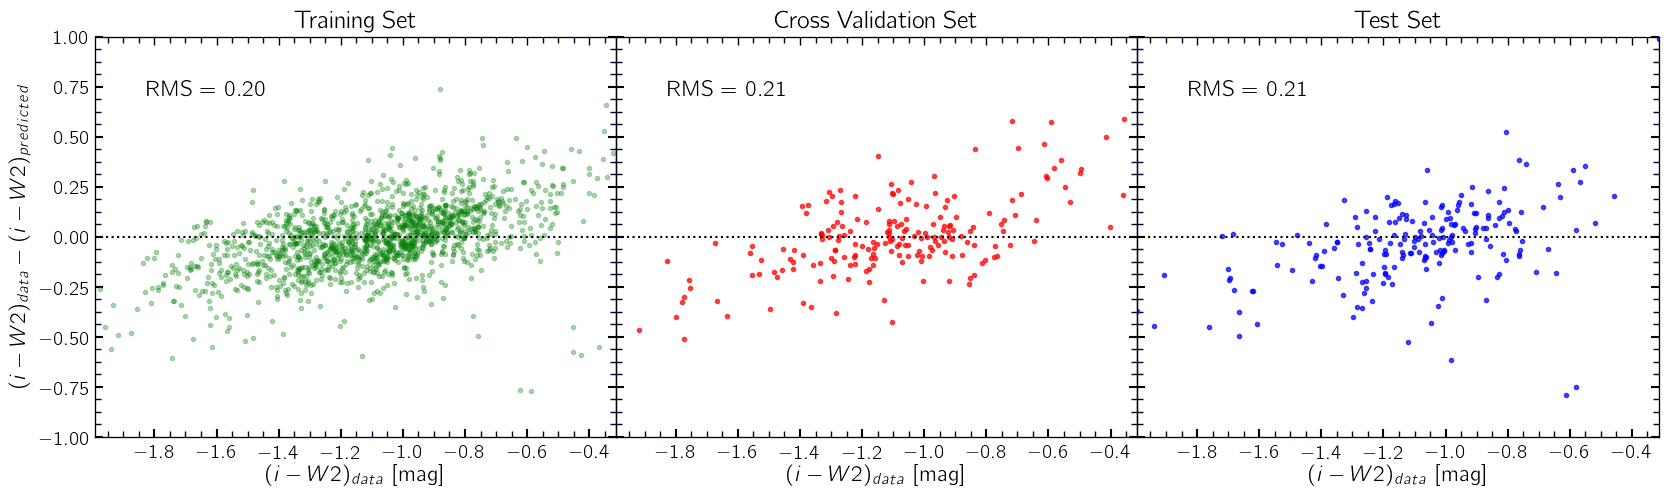

In [4]:
################################ Feature selection, regression parameters
features = ['g_r', 'r_i', 'mu50']
output   = 'i_w2'
max_depth=2000
n_estimators=2000
max_features=3
min_samples_leaf=10
bootstrap=True
################################ Regression (Random Forest)
regr, x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst = esn_RForest( \
    table_tst, table_cvl, table_trn, \
        features, output, \
            max_features=max_features, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap)
importances = regr.feature_importances_
print 'Feature Importances: ', importances
for j in range(len(features)):
    print features[j], ' --> '+'%.2f'%(importances[j]*100)+'%'

################################ Plotting
text     = 'i-W2'
text_unit = 'mag'
x0 = np.min(table_tst[output])
x1 = np.max(table_tst[output])
xlabel = r'$('+text+')'+'_{data}$'+'   ['+text_unit+']'
ylabel = r'$('+text+')'+'_{data}'+'-'+'('+text+')'+'_{predicted}$'
xlim = [x0,x1]
ylim = [-1,1]
makePlot(x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst, \
        xlim, ylim, xlabel, ylabel, plotName='RF_grI_mu50')

[0.19927885 0.04260686 0.00773285 0.03496176 0.59091029 0.12252183]


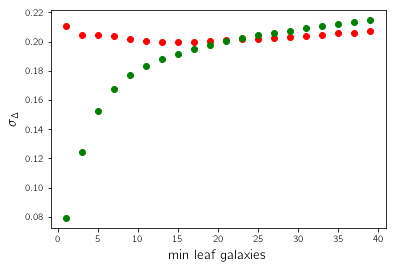

In [5]:
nLeaf = np.arange(1,40,2)
Seeds = range(300)
Stdev_trn = np.ones(shape = (len(nLeaf),len(Seeds)))
Stdev_cvl = np.ones(shape = (len(nLeaf),len(Seeds)))
importance = np.ones(shape = (len(Seeds),6))

for j in range(len(Seeds)):
    
    table_tst, table_cvl, table_trn = prepareSamples(table, Seed_cross=Seeds[j])

    ################################ Feature selection, regression parameters
    features = ['g_r', 'r_i', 'i_z', 'c21w', 'mu50', 'logWimx']
    output   = 'r_w2'
    n_estimators=1000
    max_depth = 2000
    max_features=len(features)
    bootstrap=True
    ################################ Regression (Random Forest)

    for k in range(len(nLeaf)):
        regr, x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst = esn_RForest( \
            table_tst, table_cvl, table_trn, \
                features, output, \
                    max_features=max_features, min_samples_leaf=nLeaf[k], bootstrap=bootstrap)
        Stdev_cvl[k][j]  = np.std(y_cvl-p_y_cvl)
        Stdev_trn[k][j] = np.std(y_trn-p_y_trn)
        importance[j] = regr.feature_importances_.T

plt.plot(nLeaf, np.median(Stdev_cvl,1), 'ro')
plt.plot(nLeaf, np.median(Stdev_trn,1), 'go')
plt.xlabel('min leaf galaxies',fontsize=14)
plt.ylabel(r'$\sigma_\Delta$',fontsize=14)
print np.median(importance.T,1)

plt.show()

Output:  r_w2
Feature Importances: 
g_r 	-->  2.85%
r_i 	-->  2.98%
i_z 	-->  3.90%
pc0 	-->  90.27%


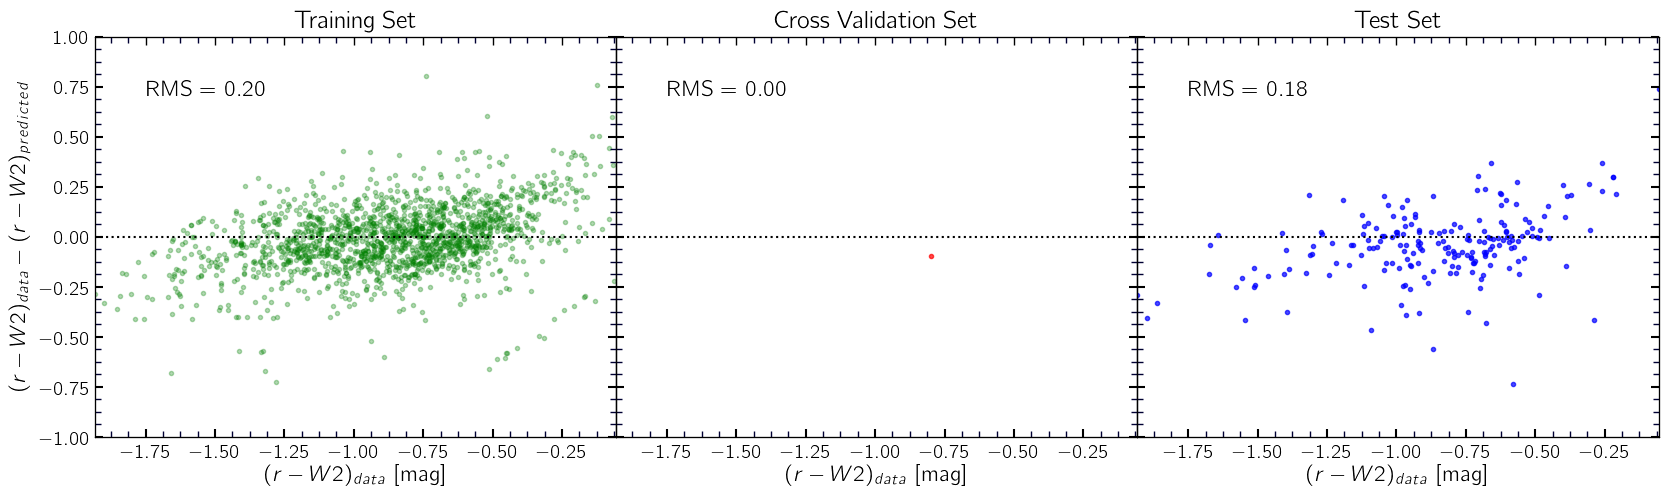

In [49]:
## Sample management
table_tst, table_cvl, table_trn = prepareSamples(table, Seed_cross=200, N_cross=1)
################################ Feature selection, regression parameters
features = ['g_r', 'r_i', 'i_z', 'pc0']
output   = 'r_w2'
max_depth=2000
n_estimators=2000
max_features=len(features)
min_samples_leaf=15
bootstrap=True
################################ Regression (Random Forest)
regr, x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst = esn_RForest( \
    table_tst, table_cvl, table_trn, \
        features, output, \
            max_features=max_features, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap)
importances = regr.feature_importances_
print 'Output: ', output
print 'Feature Importances: '#, importances
for j in range(len(features)):
    if features[j]!='logWimx':
        print features[j], '\t-->  '+'%.2f'%(importances[j]*100)+'%'
    else: print features[j], '-->  '+'%.2f'%(importances[j]*100)+'%'

################################ Plotting
text     = 'r-W2'
text_unit = 'mag'
x0 = np.min(table_tst[output])
x1 = np.max(table_tst[output])
xlabel = r'$('+text+')'+'_{data}$'+'   ['+text_unit+']'
ylabel = r'$('+text+')'+'_{data}'+'-'+'('+text+')'+'_{predicted}$'
xlim = [x0,x1]
ylim = [-1,1]
makePlot(x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst, \
        xlim, ylim, xlabel, ylabel, plotName='RF_grIz_mu50_logWimx_c21w')

55803 84 0.965 14.67
44 14.482660316042962 [9.07140113e-05]
Delta W: 0.19
-0.026309113184804556
-0.01611372502532704
0.004147458937249993
0.03352906588779597


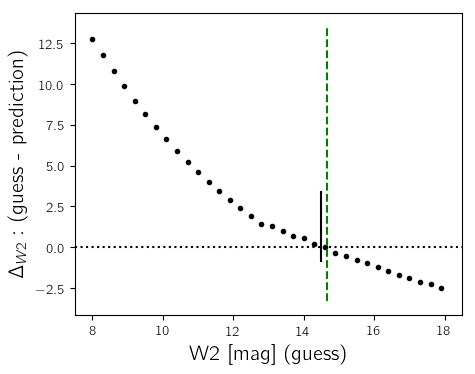

In [50]:
j = 90
PGC = table_tst['pgc'][j]
W2  = table_tst['w2'][j]
INC = table_tst["inc"][j]
P0  = table_tst["pc0"][j]
M21 = table["m21"][j]
M0  = table["logWimx"][j]
WBA = table["Wba"][j]
R50 = table["R50_w2"][j]
print PGC, INC, P0, W2
def f(w2):
    return predictor(w2, table_tst, regr, features, output, index=j)
###############################################
fig = py.figure(figsize=(5, 4), dpi=100)  
ax = fig.add_subplot(111)

for w2 in np.arange(8,18,0.3):
    delta = f(w2)
    ax.plot([w2], [delta], 'k.')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot([W2,W2], [ylim[0],ylim[1]], 'g--')
ax.plot([7.5,18.5], [0,0], 'k:')    
ax.set_xlim([7.5,18.5])
ax.set_xlabel('W2 [mag] (guess)', fontsize=15)
ax.set_ylabel(r'$\Delta_{W2}:$'+' (guess - prediction)', fontsize=15)
###############################################

out = solver(f, 8, 18, threshold=0.001) 
if out==None:
    print 'Not solvable ... !!!'
else:
    w2p, N = out
    w2p=w2p[0]
    print N, w2p, f(w2p)    
    print 'Delta W: '+'%.2f'%np.abs(w2p-W2)
    _, _, _, P0p = get_PC(w2p, M21, M0, WBA, R50)
    print redCorrect(INC, P0p, band1='g', band2='w2')-redCorrect(INC, P0, band1='g', band2='w2')
    print redCorrect(INC, P0p, band1='r', band2='w2')-redCorrect(INC, P0, band1='r', band2='w2')
    print redCorrect(INC, P0p, band1='i', band2='w2')-redCorrect(INC, P0, band1='i', band2='w2')
    print redCorrect(INC, P0p, band1='z', band2='w2')-redCorrect(INC, P0, band1='z', band2='w2')
    ax.plot([w2p,w2p], [ylim[0]/4.,ylim[1]/4.], 'k-') 



plt.show()

In [51]:
W2_lst = []
w2p_lst = []

for j in range(len(table_tst['pgc'])):
    
    PGC = table_tst['pgc'][j]
    W2  = table_tst['w2'][j]
    INC = table_tst["inc"][j]
    P0  = table_tst["pc0"][j]
    M21 = table["m21"][j]
    M0  = table["logWimx"][j]
    WBA = table["Wba"][j]
    R50 = table["R50_w2"][j]
    def f(w2):
        return predictor(w2, table_tst, regr, features, output, index=j)
    ###############################################
    out = solver(f, 8, 18, threshold=0.001) 
    if out==None:
        print 'Not solvable ... !!!'
    else:
        w2p, N = out
        w2p=w2p[0]
        W2_lst.append(W2)
        w2p_lst.append(w2p)
    ###############################################
W2_lst = np.asarray(W2_lst)
w2p_lst = np.asarray(w2p_lst)

Text(9,-0.8,'RMS = 0.21 [mag]')

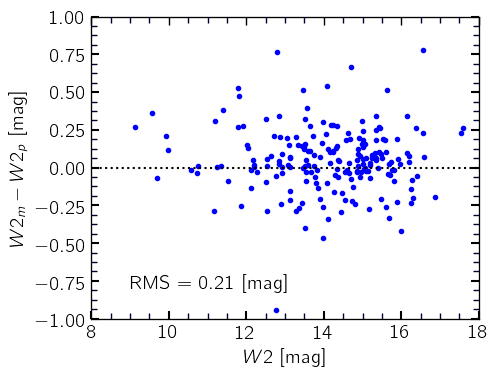

In [52]:
fig = py.figure(figsize=(5, 4), dpi=100)  
ax = fig.add_subplot(111)
ax.plot(W2_lst, W2_lst-w2p_lst, 'b.')
ax.set_xlabel(r'$W2$'+' [mag]', fontsize=14)
ax.set_ylabel(r'$W2_m-W2_p$'+' [mag]', fontsize=14)
ax.plot([7.5,18.5],[0,0], 'k:')
set_axes([ax], [8,18], [-1,1])
ax.text(9,-0.8, 'RMS = '+'%.2f'%np.std(W2_lst-w2p_lst)+' [mag]', fontsize=14, color='k')


Output:  r_w2
Feature Importances: 
g_r 	-->  19.58%
r_i 	-->  4.64%
i_z 	-->  1.91%
c21w 	-->  3.52%
mu50 	-->  57.89%
logWimx -->  12.47%


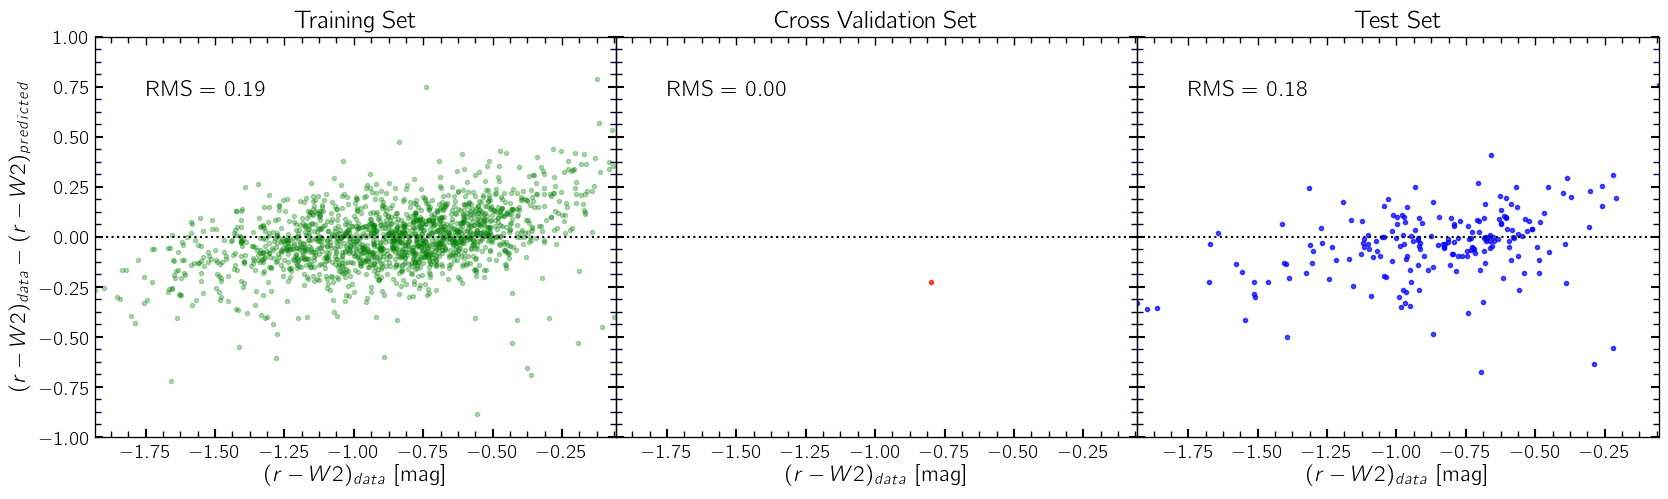

In [53]:
## Sample management
table_tst, table_cvl, table_trn = prepareSamples(table, Seed_cross=200, N_cross=1)
################################ Feature selection, regression parameters
features = ['g_r', 'r_i', 'i_z', 'c21w', 'mu50', 'logWimx']
output   = 'r_w2'
max_depth=2000
n_estimators=2000
max_features=len(features)
min_samples_leaf=15
bootstrap=True
################################ Regression (Random Forest)
regr, x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst = esn_RForest( \
    table_tst, table_cvl, table_trn, \
        features, output, \
            max_features=max_features, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap)
importances = regr.feature_importances_
print 'Output: ', output
print 'Feature Importances: '#, importances
for j in range(len(features)):
    if features[j]!='logWimx':
        print features[j], '\t-->  '+'%.2f'%(importances[j]*100)+'%'
    else: print features[j], '-->  '+'%.2f'%(importances[j]*100)+'%'

################################ Plotting
text     = 'r-W2'
text_unit = 'mag'
x0 = np.min(table_tst[output])
x1 = np.max(table_tst[output])
xlabel = r'$('+text+')'+'_{data}$'+'   ['+text_unit+']'
ylabel = r'$('+text+')'+'_{data}'+'-'+'('+text+')'+'_{predicted}$'
xlim = [x0,x1]
ylim = [-1,1]
makePlot(x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst, \
        xlim, ylim, xlabel, ylabel, plotName='RF_grIz_mu50_logWimx_c21w')

In [54]:
W2_lst = []
w2p_lst = []

for j in range(len(table_tst['pgc'])):
    
    PGC = table_tst['pgc'][j]
    W2  = table_tst['w2'][j]
    INC = table_tst["inc"][j]
    P0  = table_tst["pc0"][j]
    M21 = table["m21"][j]
    M0  = table["logWimx"][j]
    WBA = table["Wba"][j]
    R50 = table["R50_w2"][j]
    def f(w2):
        return predictor(w2, table_tst, regr, features, output, index=j)
    ###############################################
    out = solver(f, 8, 18, threshold=0.001) 
    if out==None:
        print 'Not solvable ... !!!'
    else:
        w2p, N = out
        w2p=w2p[0]
        W2_lst.append(W2)
        w2p_lst.append(w2p)
    ###############################################
W2_lst = np.asarray(W2_lst)
w2p_lst = np.asarray(w2p_lst)



Text(9,-0.8,'RMS = 0.24 [mag]')

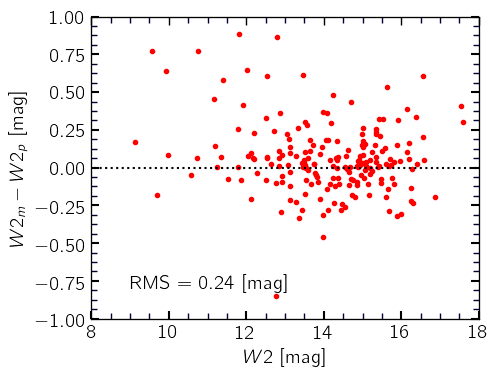

In [55]:
fig = py.figure(figsize=(5, 4), dpi=100)  
ax = fig.add_subplot(111)
ax.plot(W2_lst, W2_lst-w2p_lst, 'r.')
ax.set_xlabel(r'$W2$'+' [mag]', fontsize=14)
ax.set_ylabel(r'$W2_m-W2_p$'+' [mag]', fontsize=14)
ax.plot([7.5,18.5],[0,0], 'k:')
set_axes([ax], [8,18], [-1,1])
ax.text(9,-0.8, 'RMS = '+'%.2f'%np.std(W2_lst-w2p_lst)+' [mag]', fontsize=14, color='k')

Output:  r_w2
Feature Importances: 
Cpc1 	-->  5.09%
Cpc2 	-->  3.69%
pc0 	-->  91.21%


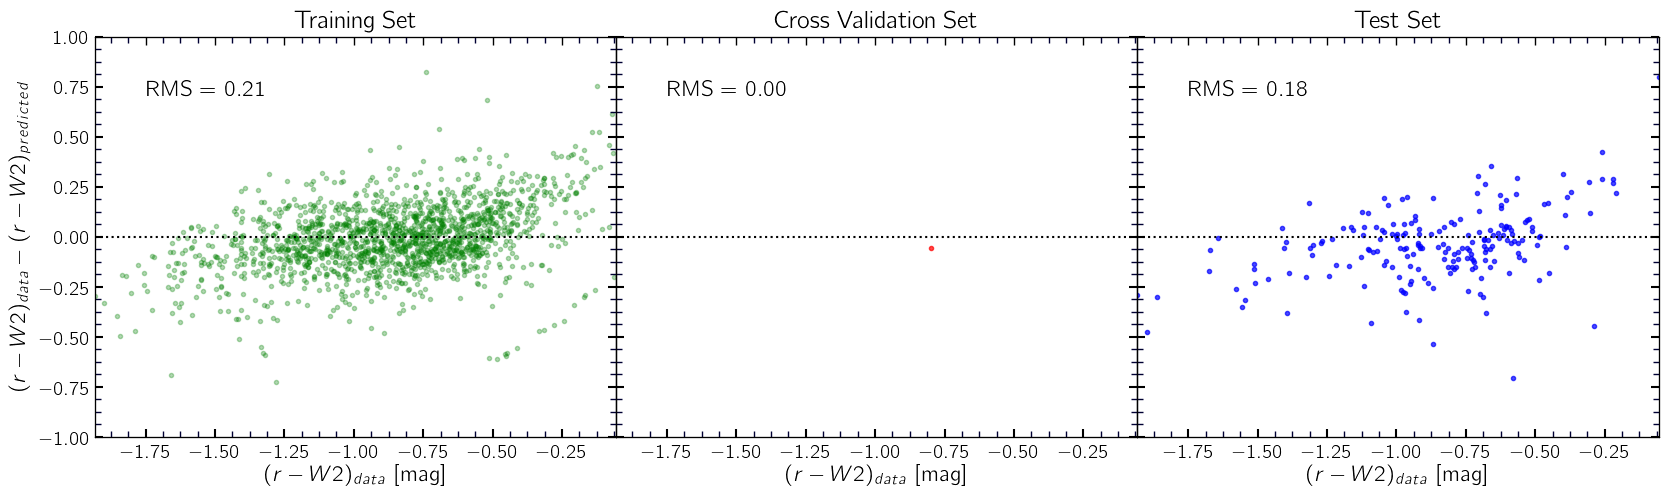

In [9]:
## Sample management
table_tst, table_cvl, table_trn = prepareSamples(table, Seed_cross=200, N_cross=1)
################################ Feature selection, regression parameters
# features = ['g_r', 'r_i', 'i_z', 'c21w', 'mu50', 'logWimx']
features = ['Cpc1','Cpc2', 'pc0']
output   = 'r_w2'
max_depth=2000
n_estimators=2000
max_features=len(features)
min_samples_leaf=15
bootstrap=True
################################ Regression (Random Forest)
regr, x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst = esn_RForest( \
    table_tst, table_cvl, table_trn, \
        features, output, \
            max_features=max_features, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap)
importances = regr.feature_importances_
print 'Output: ', output
print 'Feature Importances: '#, importances
for j in range(len(features)):
    if features[j]!='logWimx':
        print features[j], '\t-->  '+'%.2f'%(importances[j]*100)+'%'
    else: print features[j], '-->  '+'%.2f'%(importances[j]*100)+'%'

################################ Plotting
text     = 'r-W2'
text_unit = 'mag'
x0 = np.min(table_tst[output])
x1 = np.max(table_tst[output])
xlabel = r'$('+text+')'+'_{data}$'+'   ['+text_unit+']'
ylabel = r'$('+text+')'+'_{data}'+'-'+'('+text+')'+'_{predicted}$'
xlim = [x0,x1]
ylim = [-1,1]
makePlot(x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst, \
        xlim, ylim, xlabel, ylabel, plotName='RF_grIz_mu50_logWimx_c21w')

55803 84 0.965 14.67
44 14.641489112423274 [-7.20534599e-09]
Delta W: 0.03
-0.041600480409900054
-0.029570489718583115
-0.006727552435656148
0.026757341532810452


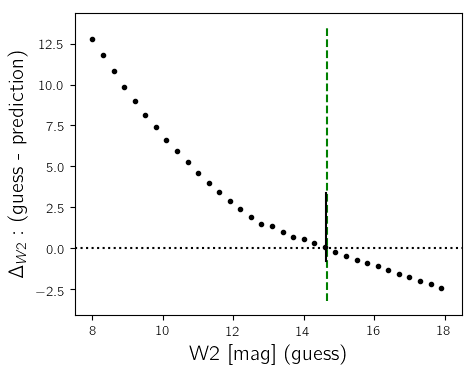

In [10]:
j = 90
PGC = table_tst['pgc'][j]
W2  = table_tst['w2'][j]
INC = table_tst["inc"][j]
P0  = table_tst["pc0"][j]
M21 = table["m21"][j]
M0  = table["logWimx"][j]
WBA = table["Wba"][j]
R50 = table["R50_w2"][j]
print PGC, INC, P0, W2
def f(w2):
    return predictor(w2, table_tst, regr, features, output, index=j)
###############################################
fig = py.figure(figsize=(5, 4), dpi=100)  
ax = fig.add_subplot(111)

for w2 in np.arange(8,18,0.3):
    delta = f(w2)
    ax.plot([w2], [delta], 'k.')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot([W2,W2], [ylim[0],ylim[1]], 'g--')
ax.plot([7.5,18.5], [0,0], 'k:')    
ax.set_xlim([7.5,18.5])
ax.set_xlabel('W2 [mag] (guess)', fontsize=15)
ax.set_ylabel(r'$\Delta_{W2}:$'+' (guess - prediction)', fontsize=15)
###############################################

out = solver(f, 8, 18, threshold=0.001) 
if out==None:
    print 'Not solvable ... !!!'
else:
    w2p, N = out
    w2p=w2p[0]
    print N, w2p, f(w2p)    
    print 'Delta W: '+'%.2f'%np.abs(w2p-W2)
    _, _, _, P0p = get_PC(w2p, M21, M0, WBA, R50)
    print redCorrect(INC, P0p, band1='g', band2='w2')-redCorrect(INC, P0, band1='g', band2='w2')
    print redCorrect(INC, P0p, band1='r', band2='w2')-redCorrect(INC, P0, band1='r', band2='w2')
    print redCorrect(INC, P0p, band1='i', band2='w2')-redCorrect(INC, P0, band1='i', band2='w2')
    print redCorrect(INC, P0p, band1='z', band2='w2')-redCorrect(INC, P0, band1='z', band2='w2')
    ax.plot([w2p,w2p], [ylim[0]/4.,ylim[1]/4.], 'k-') 



plt.show()

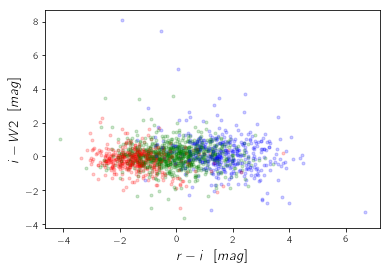

In [16]:
C1 = table_trn["Cpc1"]
C2 = table_trn["Cpc2"]
pc0 = table_trn["pc0"]

for j in range(len(C1)):
    
    if pc0[j]<-1:
        plt.plot(C1[j], C2[j], 'b.', alpha=0.2)
    if pc0[j]>1:
        plt.plot(C1[j], C2[j], 'r.', alpha=0.2)
    if -1<pc0[j]<1:
        plt.plot(C1[j], C2[j], 'g.', alpha=0.2)        

plt.xlabel(r'$r-i ~~ [mag]$', fontsize=14)
plt.ylabel(r'$i-W2 ~~ [mag]$', fontsize=14)
# plt.xlim([-1,1])
# plt.ylim([-3,3])


plt.show()

In [17]:
W2_lst = []
w2p_lst = []

for j in range(len(table_tst['pgc'])):
    
    PGC = table_tst['pgc'][j]
    W2  = table_tst['w2'][j]
    INC = table_tst["inc"][j]
    P0  = table_tst["pc0"][j]
    M21 = table["m21"][j]
    M0  = table["logWimx"][j]
    WBA = table["Wba"][j]
    R50 = table["R50_w2"][j]
    def f(w2):
        return predictor(w2, table_tst, regr, features, output, index=j)
    ###############################################
    out = solver(f, 8, 18, threshold=0.001) 
    if out==None:
        print 'Not solvable ... !!!'
    else:
        w2p, N = out
        w2p=w2p[0]
        W2_lst.append(W2)
        w2p_lst.append(w2p)
    ###############################################
W2_lst = np.asarray(W2_lst)
w2p_lst = np.asarray(w2p_lst)


Text(9,-0.8,'RMS = 0.25 [mag]')

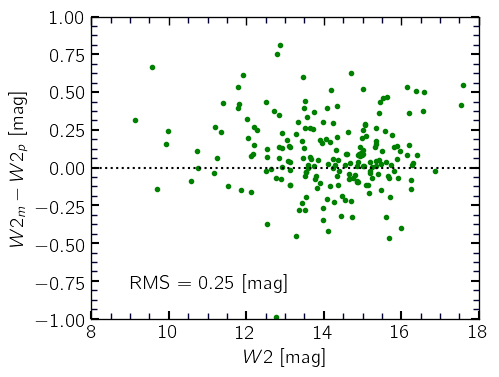

In [18]:
fig = py.figure(figsize=(5, 4), dpi=100)  
ax = fig.add_subplot(111)
ax.plot(W2_lst, W2_lst-w2p_lst, 'g.')
ax.set_xlabel(r'$W2$'+' [mag]', fontsize=14)
ax.set_ylabel(r'$W2_m-W2_p$'+' [mag]', fontsize=14)
ax.plot([7.5,18.5],[0,0], 'k:')
set_axes([ax], [8,18], [-1,1])
ax.text(9,-0.8, 'RMS = '+'%.2f'%np.std(W2_lst-w2p_lst)+' [mag]', fontsize=14, color='k')

In [26]:
## Sample management
table_tst, table_cvl, table_trn = prepareSamples(table, Seed_cross=200, N_cross=1)
################################ Feature selection, regression parameters
output   = 'r_w2'
max_depth=2000
n_estimators=2000
min_samples_leaf=15
bootstrap=True
################################ Regression (Random Forest)

features0 = ['g_r', 'r_i', 'i_z', 'c21w', 'mu50', 'logWimx']
max_features=len(features0)
regr0, x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst = esn_RForest( \
    table_tst, table_cvl, table_trn, \
        features0, output, \
            max_features=max_features, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap)
importances = regr0.feature_importances_
print 'Output: ', output
print 'Feature Importances: '#, importances
for j in range(len(features0)):
    if features0[j]!='logWimx':
        print features0[j], '\t-->  '+'%.2f'%(importances[j]*100)+'%'
    else: print features0[j], '-->  '+'%.2f'%(importances[j]*100)+'%'

features1 = ['g_r', 'r_i', 'i_z', 'pc0']
max_features=len(features1)
regr1, x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst = esn_RForest( \
    table_tst, table_cvl, table_trn, \
        features1, output, \
            max_features=max_features, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap)
importances = regr1.feature_importances_
print 'Output: ', output
print 'Feature Importances: '#, importances
for j in range(len(features1)):
    if features1[j]!='logWimx':
        print features1[j], '\t-->  '+'%.2f'%(importances[j]*100)+'%'
    else: print features1[j], '-->  '+'%.2f'%(importances[j]*100)+'%'

features2 = ['Cpc1', 'c21w', 'mu50', 'logWimx']
max_features=len(features2)
regr2, x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst = esn_RForest( \
    table_tst, table_cvl, table_trn, \
        features2, output, \
            max_features=max_features, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap)
importances = regr2.feature_importances_
print 'Output: ', output
print 'Feature Importances: '#, importances
for j in range(len(features2)):
    if features2[j]!='logWimx':
        print features2[j], '\t-->  '+'%.2f'%(importances[j]*100)+'%'
    else: print features2[j], '-->  '+'%.2f'%(importances[j]*100)+'%'

features3 = ['Cpc1', 'pc0']
max_features=len(features3)
regr3, x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst = esn_RForest( \
    table_tst, table_cvl, table_trn, \
        features3, output, \
            max_features=max_features, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap)
importances = regr3.feature_importances_
print 'Output: ', output
print 'Feature Importances: '#, importances
for j in range(len(features3)):
    if features3[j]!='logWimx':
        print features3[j], '\t-->  '+'%.2f'%(importances[j]*100)+'%'
    else: print features3[j], '-->  '+'%.2f'%(importances[j]*100)+'%'


Output:  r_w2
Feature Importances: 
g_r 	-->  17.79%
r_i 	-->  4.47%
i_z 	-->  1.98%
c21w 	-->  3.94%
mu50 	-->  59.09%
logWimx -->  12.73%
Output:  r_w2
Feature Importances: 
g_r 	-->  2.75%
r_i 	-->  3.02%
i_z 	-->  3.88%
pc0 	-->  90.35%
Output:  r_w2
Feature Importances: 
Cpc1 	-->  21.31%
c21w 	-->  3.58%
mu50 	-->  64.69%
logWimx -->  10.41%
Output:  r_w2
Feature Importances: 
Cpc1 	-->  6.40%
pc0 	-->  93.60%


55803 84 0.965 14.67
48 14.704389300684301 [-7.61560104e-09]
Delta W: 0.03
-0.04822230371046543
-0.03545256321373502
-0.011600313962147113
0.023498159142537445


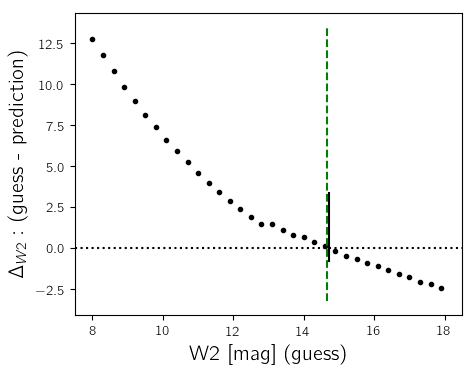

In [30]:
j = 90
PGC = table_tst['pgc'][j]
W2  = table_tst['w2'][j]
INC = table_tst["inc"][j]
P0  = table_tst["pc0"][j]
M21 = table["m21"][j]
M0  = table["logWimx"][j]
WBA = table["Wba"][j]
R50 = table["R50_w2"][j]
print PGC, INC, P0, W2
def f(w2):
    return predictor(w2, table_tst, regr3, features3, output, index=j)
###############################################
fig = py.figure(figsize=(5, 4), dpi=100)  
ax = fig.add_subplot(111)

for w2 in np.arange(8,18,0.3):
    delta = f(w2)
    ax.plot([w2], [delta], 'k.')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot([W2,W2], [ylim[0],ylim[1]], 'g--')
ax.plot([7.5,18.5], [0,0], 'k:')    
ax.set_xlim([7.5,18.5])
ax.set_xlabel('W2 [mag] (guess)', fontsize=15)
ax.set_ylabel(r'$\Delta_{W2}:$'+' (guess - prediction)', fontsize=15)
###############################################

out = solver(f, 8, 18, threshold=0.001) 
if out==None:
    print 'Not solvable ... !!!'
else:
    w2p, N = out
    w2p=w2p[0]
    print N, w2p, f(w2p)    
    print 'Delta W: '+'%.2f'%np.abs(w2p-W2)
    _, _, _, P0p = get_PC(w2p, M21, M0, WBA, R50)
    print redCorrect(INC, P0p, band1='g', band2='w2')-redCorrect(INC, P0, band1='g', band2='w2')
    print redCorrect(INC, P0p, band1='r', band2='w2')-redCorrect(INC, P0, band1='r', band2='w2')
    print redCorrect(INC, P0p, band1='i', band2='w2')-redCorrect(INC, P0, band1='i', band2='w2')
    print redCorrect(INC, P0p, band1='z', band2='w2')-redCorrect(INC, P0, band1='z', band2='w2')
    ax.plot([w2p,w2p], [ylim[0]/4.,ylim[1]/4.], 'k-') 



plt.show()

0 [12.457188017267912, 12.466043433887938, 12.272542874591766, 12.384983962484684] 12.421085989876298 12.526
1 [15.589156546046482, 15.510966488342202, 15.597484968838788, 15.56232470667142] 15.57574062635895 15.614
2 [14.973691490803207, 14.886207247714045, 14.97334107160616, 14.959449936274696] 14.96639550394043 14.853
3 [11.284394715443428, 11.33595356169788, 11.403664853473499, 11.220639613558944] 11.310174138570654 11.353
4 [14.674651967268545, 14.61141700870534, 14.706855847624837, 14.703163205021976] 14.68890758614526 14.644
5 [14.120340625767051, 14.067391946855883, 14.118817909683662, 13.976490471093914] 14.093104928269772 14.17
6 [15.097869578219766, 15.080622076520612, 15.072666180992021, 15.16440386825618] 15.089245827370188 15.336
7 [15.427107509549616, 15.331891281984072, 15.410474620461224, 15.381673134978914] 15.39607387772007 15.432
8 [12.312785859720433, 12.303083586948311, 12.35655719655596, 12.127330696932031] 12.307934723334373 12.276
9 [11.781258182930642, 11.2679

76 [13.717232202992415, 13.671517146546694, 13.785776655593368, 13.79341340383926] 13.751504429292892 13.437
77 [14.451247979890995, 14.461065749083536, 14.247150963371817, 14.31399701141197] 14.382622495651482 13.99
78 [14.92074117075102, 14.965965529521037, 15.106643700826112, 15.210331956220564] 15.036304615173574 14.737
79 [13.5218375786367, 13.567656444838972, 13.613524771483142, 13.623284990415549] 13.590590608161058 13.593
80 [13.711331046091194, 13.748681758805043, 13.83703431491291, 13.80189618000641] 13.775288969405727 13.749
81 [13.469472260479007, 13.372994730102597, 13.630642211355935, 13.657086112053644] 13.550057235917471 13.648
82 [12.84779912507629, 12.946053416321805, 12.826998019976932, 12.843427624546214] 12.845613374811252 13.461
83 [13.498455884059865, 13.506303708015382, 13.547055902435105, 13.585447923171085] 13.526679805225243 13.511
84 [11.94024612096407, 12.047075161557608, 11.960572804154642, 12.035572055547576] 11.99807242985111 12.803
85 [14.31708472042361

151 [13.577811070418452, 13.515998521514913, 13.562362982904101, 13.533904334135919] 13.54813365852001 13.726
152 [13.720161482883729, 13.54559916864251, 13.781854434493631, 13.729826881072963] 13.724994181978346 14.09
153 [13.241438183503398, 13.282137517096777, 13.205522432798945, 13.220741381236259] 13.231089782369828 13.123
154 [14.321275954029717, 14.336063397010141, 14.381699638237398, 14.441902126692051] 14.35888151762377 14.327
155 [14.940845305789212, 14.80821265374325, 15.013036099449273, 14.949063258429486] 14.94495428210935 14.851
156 [14.365539367916725, 14.434459573558152, 14.490687253362625, 14.568576780768872] 14.462573413460388 14.097
157 [17.05614084428905, 17.06130139455678, 16.967250968139304, 16.87294305734245] 17.01169590621418 16.866
158 [13.528444270486645, 13.468419785448726, 13.564894886010604, 13.594514777235919] 13.546669578248625 13.529
159 [14.247123232104446, 14.190760144893126, 14.248853972849947, 14.273911885499732] 14.247988602477196 14.312
160 [13.881

Text(9,-0.8,'RMS = 0.22 [mag]')

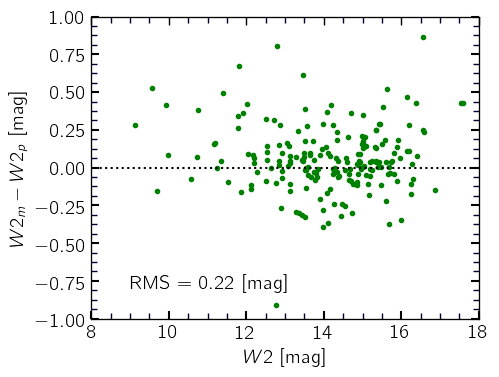

In [33]:
W2_lst = []
w2p_lst = []

for j in range(len(table_tst['pgc'])):
    
    PGC = table_tst['pgc'][j]
    W2  = table_tst['w2'][j]
    INC = table_tst["inc"][j]
    P0  = table_tst["pc0"][j]
    M21 = table["m21"][j]
    M0  = table["logWimx"][j]
    WBA = table["Wba"][j]
    R50 = table["R50_w2"][j]
    WW = []
    regr_lst = [regr0, regr1, regr2, regr3]
    features_lst = [features0, features1, features2, features3]
    for jj in range(4):
        
        regr = regr_lst[jj]
        features = features_lst[jj]
        def f(w2):
            return predictor(w2, table_tst, regr, features, output, index=j)
    ###############################################
        out = solver(f, 8, 18, threshold=0.001) 
        if out==None:
            print 'Not solvable ... !!!'
        else:
            w2p, N = out
            WW.append(w2p[0])
    
    w2p_lst.append(np.median(WW))
    W2_lst.append(W2)
    
    print j, WW, np.median(WW), W2
    ###############################################
    
    
W2_lst = np.asarray(W2_lst)
w2p_lst = np.asarray(w2p_lst)

fig = py.figure(figsize=(5, 4), dpi=100)  
ax = fig.add_subplot(111)
ax.plot(W2_lst, W2_lst-w2p_lst, 'g.')
ax.set_xlabel(r'$W2$'+' [mag]', fontsize=14)
ax.set_ylabel(r'$W2_m-W2_p$'+' [mag]', fontsize=14)
ax.plot([7.5,18.5],[0,0], 'k:')
set_axes([ax], [8,18], [-1,1])
ax.text(9,-0.8, 'RMS = '+'%.2f'%np.std(W2_lst-w2p_lst)+' [mag]', fontsize=14, color='k')